# 🧠 Machine Learning-Driven Model to Enhance Discovery Potential in HEP

## 📄 Notebook Purpose
This notebook processes **ATLAS Run-2 Open Data (2015–2016)** provided in the **PhysLite** format.  
Its goal is to extract a selected set of **low-level physics variables** useful for **anomaly detection studies** in high-energy physics.

Using a combination of **ROOT** and **parallel processing tools (Dask)**, the notebook reads `.root` files, applies variable selection and filtering, and converts the data into structured tabular formats (`.h5` and `.csv`).

This preprocessing step prepares the data for downstream machine learning tasks—especially **unsupervised anomaly detection**, which aims to identify rare or non-Standard Model signatures in proton-proton collision events.

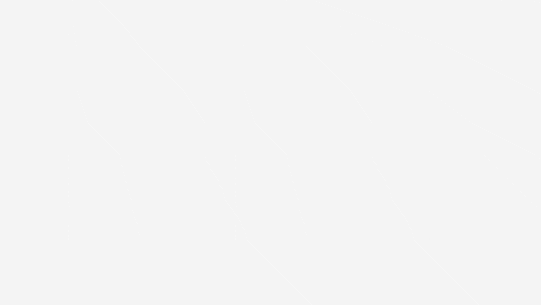

---

# 🔍 Anomaly Detection in High-Energy Physics Using Transformers

In high-energy physics (HEP), discovering signals of **Beyond the Standard Model (BSM)** physics often means identifying rare and unexpected events buried in vast amounts of collision data. Traditional search techniques rely on specific hypotheses and selection cuts, but **unsupervised anomaly detection** offers a **model-independent** way to spot these hidden signals.

---

## ❓ What is Anomaly Detection?

**Anomaly detection** refers to identifying events that deviate significantly from expected behavior, which is learned from known **Standard Model (SM)** processes. These outliers may indicate **new physics**.

Rather than relying on labeled signal events (which are unknown in discovery studies), we train a model **only on background data**. The goal is to learn the structure of SM events and then identify events that don’t fit—potential anomalies.

---

## 🤖 Using Transformers for Anomaly Detection

In this analysis, we apply a **Transformer-based reconstruction model** to ATLAS Open Data from Run 2 (2015–2016), focusing on rare event detection.

The model is trained on **SM background-only events** using low-level physics observables such as:

- Jet and lepton kinematics  
- Photon energy  
- Missing transverse energy (MET)  
- Electromagnetic and hadronic calorimeter deposits  
- Event topology features

We use a modified **TabTransformer** architecture, optimized for tabular HEP data. The model learns to reconstruct input features from SM events. During inference, we compute a **reconstruction loss** for each event. High loss values indicate poor reconstruction—potentially **anomalous** or BSM events.

---

## ⚡ Why Transformers?

Compared to traditional methods like **Variational Autoencoders (VAEs)**:

- Transformers better model **inter-variable dependencies**
- They scale well with **high-dimensional inputs**
- They operate directly on **low-level features**, enhancing interpretability

Our TabTransformer uses a **weighted loss function** to give appropriate importance to each feature, improving t



h](attachment:93ea99a8-9845-447e-bee0-843d1b453b71.gif)

---

## 📈 Performance and Interpretability

- On SM background samples, the model reconstructs events accurately
- On BSM-like samples (e.g., SUSY, Exotic), the reconstruction loss increases significantly
- This separation allows the model to **flag anomalies effectively**
- Since the model is trained in an **unsupervised*---

## �Model architecturepsUsing a transformer model with encode decoder setuplude:
Embeddingalybased on the shape of the variablesDataf encoderrvabnetwork use the catogorized variables in the encoderles**decoder**  trained to reconstruct the eventtamodel architecturenigif)
---niqransformer_model.gif)endent searches** in HEP using state-of-the-art machine learning techniques.

---

## 🛠 How to Run the Notebook

To run all cells in sequence:
- Click **Cell → Run All**

To propagate a change to the rest of the notebook:
- Click **Cell → Run All Below**

To run a single cell:
- Click **Cell → Run Cells**, or use the shortcut **Shift+Enter**

📚 For more help, visit: [How To Use Jupyter Notebooks](https://jupyter-notebook.readthedocs.io/en/stable/)

---

## 🎯 Learning Outcomes

By the end of this notebook, you will be able to:

✅ Process large particle physics datasets using selections and cuts  
✅ Understand key steps in a particle physics data analysis pipeline  
✅ Apply these me

# 🧪 The Analysis

## 🔧 Setup

We will use modern tools designed to efficiently process large datasets from HEP experiments like ATLAS.

### 🛠 Key Tools

- **Dask RDataFrame** (from ROOT):  
  A parallelized and scalable version of `RDataFrame`, optimized for distributed analysis on large datasets in Jupyter notebooks.

- **Dask**:  
  Enables scalable parallel computation in Python. It powers `RDataFrame` under the hood to efficiently process large collision datasets.

- **ROOT**:  
  A comprehensive data analysis framework in high-energy physics (HEP), used to interact with `.root` files, apply selection criteria, compute physics quantities like invariant masses, and generate plots.  
  > ℹ️ We suppress non-critical warning messages using `ROOT.gErrorIgnoreLevel = ROOT.kError`.

- **pandas**:  
  Used for structured data manipulation and exporting data into `.csv` files.

- **numpy**:  
  Provides efficient numerical operations and array management.

- **distributed (Dask)**:  
  Enables scalable and parallel processing using `Client` and `LocalCluster` to handle large datasets in memory-efficient ways.

- **matplotlib** and **seaborn**:  
  Used for visualizing distributions, correlations, and results with high-quality plots.

- **time** and **warnings**:  
  Utility modules used to monitor performance and control warniike ATLAS.


---



With this setup, you can analyze real ATLAS Open Data using scalable tools right from your browser!

## Setup

In this notebook, we will use modern tools designed to efficiently process large datasets from high-energy physics experiments like ATLAS.

---


from dask.distributed import Client

client = Client("tls://10.100.10.194:32064")
client

In [1]:
from dask.distributed import Client

client = Client("tls://10.100.139.49:30701")


In [2]:
""" importing the modules and the pakages"""
import ROOT
import pandas as pd
from distributed import Client , LocalCluster
import numpy as np
import time
import warnings
ROOT.gErrorIgnoreLevel = ROOT.kError
import matplotlib.pyplot as plt
import seaborn as sns


print("all pakages are imported")

all pakages are imported


In [3]:




def create_dask_client(scheduler: str, ncores: int, hosts: str, scheduler_address: str) -> Client:
    """
    Initializing the Dask distributed client based on the scheduler type.

    Parameters:
    - scheduler (str): Type of scheduler to use ('dask-local', 'dask-ssh', or 'dask-remote').
    - ncores : Number of cores/ workers.
    - hosts : hostnames.
    - scheduler_address (str): Address of a remote scheduler

    Returns:
    - Dask Client connected to the cluster.
    """

    # Local cluster: spawns a multi-process cluster on the local machine
    if scheduler == "dask-local":
        lc = LocalCluster(n_workers=ncores, threads_per_worker=1, processes=True)
        return Client(lc)

    # SSH cluster: connects to a list of remote workers over SSH
    if scheduler == "dask-ssh":
        workers = hosts.split(",")
        print(f"Using worker nodes: {workers=}")
        sshc = SSHCluster(
            workers,
            connect_options={"known_hosts": None},  # disables strict host checking
            worker_options={
                "nprocs": ncores,             # number of processes (cores) per worker
                "nthreads": 1,                # one thread per process
                "memory_limit": "32GB",       # memory limit per worker
            },
        )
        return Client(sshc)

    # Remote cluster: connects to an already running Dask scheduler at a given address
    if scheduler == "dask-remote":
        return Client(scheduler_address)

    # Raise an error if the scheduler type is invalid
    raise ValueError(
        f"Unexpected scheduling mode '{scheduler}'. Valid modes are ['dask-local', 'dask-ssh', 'dask-remote']."
    )


## Selected Variables for Anomaly Detection Study

The following list of variables has been selected from the ATLAS Open Data to characterize various physics objects and event properties. These variables serve as important features (or *candidates*) for our anomaly detection model, which aims to identify rare or unexpected patterns in high-energy collision events.

- **Run Information**  
  - `EventInfoAuxDyn.runNumber` - Identifies the run number for each event.

- **Jet Kinematics and Substructure**  
  Variables describing the momentum, angular distributions, and internal structure of jets, including transverse momentum (`pt`), pseudorapidity (`eta`), azimuthal angle (`phi`), mass (`m`), and other jet-shape observables like width and energy fractions.

- **Missing Transverse Energy (MET)**  
  Calorimeter-based and track-based MET components (`px`, `py`, `pz`, energy, and sum of transverse momentum), which are crucial for detecting invisible particles or energy imbalance.

- **Large-R Jets and Constituents**  
  Features describing larger jets reconstructed with different algorithms, along with their constituent momenta, providing insights into boosted objects.

- **Photon Variables**  
  Photon transverse momentum, angular coordinates, isolation variables, and quality flags.

- **Event Shape Variables**  
  Quantities characterizing the overall energy flow and density within the event.

- **Primary Vertex and Tracking Variables**  
  Positions of primary interaction vertices and track parameters related to charged particle trajectories.

- **Electron and Muon Kinematics**  
  Key variables describing leptons in the event.

- **b-Tagging Discriminants**  
  Variables used to identify jets likely originating from b-quarks.

Together, these variables provide a comprehensive physics description of each collision event. Our anomaly detection algorithm will leverage these features to detect deviations from standard model expectations, potentially revealing new physics phenomena.


In [4]:
columns = [
    
    "EventInfoAuxDyn.runNumber",                 # [0] Run Information

    # [1–4] Jet Kinematics
    "AnalysisJetsAuxDyn.pt",                     # [1]
    "AnalysisJetsAuxDyn.eta",                    # [2]
    "AnalysisJetsAuxDyn.phi",                    # [3]
    "AnalysisJetsAuxDyn.m",                      # [4]

    # [5–8] Jet Substructure
    "AnalysisJetsAuxDyn.JVFCorr",                # [5]
    "AnalysisJetsAuxDyn.EMFrac",                 # [6]
    "AnalysisJetsAuxDyn.PSFrac",                 # [7]
    "AnalysisJetsAuxDyn.Width",                  # [8]

    # [9–13] Calorimeter-based MET
    "MET_calpx",                                 # [9]
    "MET_calpy",                                 # [10]
    "MET_calpz",                                 # [11]
    "MET_cale",                                  # [12]
    "MET_calsumpt",                              # [13]

    # [14–17] Large-R Jet (UFOCSSK) Kinematics
    "AntiKt10UFOCSSKJetsAux.pt",                 # [14]
    "AntiKt10UFOCSSKJetsAux.eta",                # [15]
    "AntiKt10UFOCSSKJetsAux.phi",                # [16]
    "AntiKt10UFOCSSKJetsAux.m",                  # [17]

    # [18–21] Jet Constituent Scale Momenta
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt",   # [18]
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta",  # [19]
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",  # [20]
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",    # [21]

    # [22–27] Photon Information
    "AnalysisPhotonsAuxDyn.pt",                  # [22]
    "AnalysisPhotonsAuxDyn.eta",                 # [23]
    "AnalysisPhotonsAuxDyn.phi",                 # [24]
    "AnalysisPhotonsAuxDyn.DFCommonPhotonsIsEMTight",  # [25]
    "AnalysisPhotonsAuxDyn.topoetcone20",        # [26]
    "AnalysisPhotonsAuxDyn.topoetcone40",        # [27]

    # [28] Event Shape
    "Kt4EMPFlowEventShapeAuxDyn.Density",        # [28]

    # [29–31] Core MET (Track-based)
    "MET_Core_AnalysisMETAuxDyn.mpx",            # [29]
    "MET_Core_AnalysisMETAuxDyn.mpy",            # [30]
    "MET_Core_AnalysisMETAuxDyn.sumet",          # [31]

    # [32–34] Primary Vertex
    "PrimaryVerticesAuxDyn.x",                   # [32]
    "PrimaryVerticesAuxDyn.y",                   # [33]
    "PrimaryVerticesAuxDyn.z",                   # [34]

    # [35–38] Calorimeter Cluster Variables
    "egammaClustersAuxDyn.calE",                 # [35]
    "egammaClustersAuxDyn.calEta",               # [36]
    "egammaClustersAuxDyn.calPhi",               # [37]
    "egammaClustersAuxDyn.calM",                 # [38]

    # [39–44] Large-R Jet Variables
    "AnalysisLargeRJetsAuxDyn.pt",               # [39]
    "AnalysisLargeRJetsAuxDyn.eta",              # [40]
    "AnalysisLargeRJetsAuxDyn.phi",              # [41]
    "AnalysisLargeRJetsAuxDyn.m",                # [42]
    "AnalysisLargeRJetsAuxDyn.Tau1_wta",         # [43]
    "AnalysisLargeRJetsAuxDyn.Tau2_wta",         # [44]

    # [45–47] Tracking Variables
    "InDetTrackParticlesAuxDyn.d0",              # [45]
    "InDetTrackParticlesAuxDyn.z0",              # [46]
    "InDetTrackParticlesAuxDyn.qOverP",          # [47]

    # [48–50] Electron Variables
    "AnalysisElectronsAuxDyn.pt",                # [48]
    "AnalysisElectronsAuxDyn.eta",               # [49]
    "AnalysisElectronsAuxDyn.phi",               # [50]

    # [51–53] Muon Variables
    "AnalysisMuonsAuxDyn.pt",                    # [51]
    "AnalysisMuonsAuxDyn.eta",                   # [52]
    "AnalysisMuonsAuxDyn.phi",                   # [53]

    # [54] b-Tagging Discriminant
    "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",  # [54]
]


## Utility Functions for Data Preparation

### `pad_or_fill(sets, max_count)`
Pads or fills a list of dictionaries (`sets`) to a fixed length (`max_count`).  
- If the input list has fewer than `max_count` entries, it pads with a default dictionary where all keys have value `-99`.  
- Useful for ensuring consistent input sizes for models when the number of objects varies per event.

---

### `filter_and_pad_or_fill(met_cals, max_count)`
Filters a list of MET (Missing Transverse Energy) dictionaries to remove entries with zero momentum (`px == 0`), then pads the filtered list to `max_count`.  
- Pads with a default MET dictionary with all fields set to `-99` if needed.  
- Ensures valid MET entries are passed to the model and maintains consistent input size.

---

### `safe_column_extraction(df, branch, num_entries, default_val=-99)`
Attempts to extract a branch (column) from a ROOT `RDataFrame` as a numpy array.  
- If extraction fails or the branch is missing, returns a list filled with default values (`-99`).  
- Handles variable data types and ensures robust fallback for missing data during preprocessing.


In [5]:

""" padding and filling dict with default value)"""
def pad_or_fill(sets, max_count):
    padded = []

    # Create a default dictionary with all keys from the first set and values as -99
    # Used to padding when fewer than max_count objects are present
    
    if sets:
        default_entry = {k: -99 for k in sets[0].keys()}
    else:
        default_entry = {}

    for i in range(max_count):
        if i < len(sets):
            padded.append(sets[i])  # Use existing entry if available
        else:
            padded.append(default_entry.copy())  # Pad with default if not enough entries

    return padded

""" padding and filling dict of variables with nested structure with default value) """    
def filter_and_pad_or_fill(met_cals, max_count):
    # Define a default entry with -99 values (used for padding or empty case)
    default_entry = {'px': -99, 'py': -99, 'pz': -99, 'e': -99, 'sumpt': -99}
    
    # If list is empty, return max_count default entries
    if not met_cals:
        return [default_entry for _ in range(max_count)]
    
    # Filter out MET entries with px == 0 (considered invalid or meaningless)
    filtered = [entry for entry in met_cals if entry.get("px", 0) != 0]

    # If all entries are filtered out (all px == 0), return default padded list
    if not filtered:
        return [default_entry for _ in range(max_count)]

    # Return first max_count valid entries and pad if fewer
    return filtered[:max_count] + [default_entry] * max(0, max_count - len(filtered))
    
"""Robust data extraction Fallback mechanism"""
def safe_column_extraction(df, branch, num_entries, default_val=-99):
    try:
        data = df.AsNumpy([branch])[branch]

        # Handle case where data is a list/array of scalars
        if isinstance(data, np.ndarray) and np.issubdtype(data.dtype, np.number):
            return [np.array([val]) for val in data]
        # Handle case where each element is already an array (no change needed)
        else:
            return data
        
    except Exception as e:
        # If branch is missing or unreadable, fill with default value
        return [np.full(1, default_val)] * num_entries

## Physics Utility Functions

### `delta_R(eta1, phi1, eta2, phi2)`
Calculates the angular separation ($\Delta R$) between two candidates in pseudorapidity ($\eta$) and azimuthal angle ($\phi$) space.  
- $\Delta R$ is defined as $\sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}$, with $\Delta \phi$ properly wrapped within $[0, 2\pi)$.

---




### `invariant_mass(pt1, eta1, phi1, mass1, pt2, eta2, phi2, mass2)`
Computes the invariant mass of two particles given their transverse momentum ($p_T$), pseudorapidity ($\eta$), azimuthal angle ($\phi$), and mass.  
- Uses the energy-momentum conservation formula:  
  $m = \sqrt{(E_1 + E_2)^2 - |\vec{p}_1 + \vec{p}_2|^2}$

---




### `transverse_mass_general(HT, MET_px, MET_py, pT_sum_x, pT_sum_y)`
Computes a generalized transverse mass combining the scalar sum of transverse energies ($H_T$), missing transverse energy (MET) components, and visible transverse momentum.  
- The transverse mass is calculated using:  
  $M_T = \sqrt{2 \cdot H_T \cdot |\vec{E}_T^{\text{miss}}| \cdot (1 - \cos(\Delta\phi))}$  
  where  
  $|\vec{E}_T^{\text{miss}}| = \sqrt{\text{MET}_{px}^2 + \text{MET}_{py}^2}$  
  and  
  $\Delta\phi = \arctan2(pT\_sum\_y, pT\_sum\_x) - \arctan2(MET\_py, MET\_px)$


In [6]:
def delta_R(eta1, phi1, eta2, phi2):
    """
    angular separation (ΔR) between two candidates in η–ϕ space.

    Parameters:
    - eta1, phi1: Pseudorapidity and azimuthal angle of the first candidate.
    - eta2, phi2: Pseudorapidity and azimuthal angle of the second candidate.

    Returns:
    - ΔR = sqrt((Δη)^2 + (Δϕ)^2)
    """
    delta_eta = eta1 - eta2
    delta_phi = abs(phi1 - phi2)
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi  # Wrap around 2π
    return np.sqrt(delta_eta**2 + delta_phi**2)

def invariant_mass(pt1, eta1, phi1, mass1, pt2, eta2, phi2, mass2):
    """
    invariant mass of two particles .

    Parameters:
    - pt1, eta1, phi1, mass1: kinematic properties of the first particle
    - pt2, eta2, phi2, mass2: kinematic properties of the second particle

    """
    energy1 = np.sqrt(pt1**2 + (pt1 * np.sinh(eta1))**2 + mass1**2)
    energy2 = np.sqrt(pt2**2 + (pt2 * np.sinh(eta2))**2 + mass2**2)

    # Momentum components
    px1, px2 = pt1 * np.cos(phi1), pt2 * np.cos(phi2)
    py1, py2 = pt1 * np.sin(phi1), pt2 * np.sin(phi2)
    pz1, pz2 = pt1 * np.sinh(eta1), pt2 * np.sinh(eta2)

    mass = np.sqrt((energy1 + energy2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
    return mass


def calculate_centrality(etas, phis):
    """
    Calculate the central (average) η and ϕ position of a set of objects.

    Parameters:
    - etas: list or array of pseudorapidities
    - phis: list or array of azimuthal angles

    """
    avg_eta = np.mean(etas)
    avg_phi = np.mean(phis)
    return avg_eta, avg_phi

def transverse_mass_general(HT, MET_px, MET_py, pT_sum_x, pT_sum_y):
    """
    Computing the generalized transverse mass using the scalar suum of HT, MET vector, 
    and visible transverse momentum.
    """
    MET_pt = np.sqrt(MET_px**2 + MET_py**2)  # Magnitude of MET
    total_pT_phi = np.arctan2(pT_sum_y, pT_sum_x)  # Visible pT direction
    MET_phi = np.arctan2(MET_py, MET_px)  # MET direction
    delta_phi = total_pT_phi - MET_phi
    return np.sqrt(2 * HT * MET_pt * (1 - np.cos(delta_phi)))





### 📦 `process_dask` Function: Distributed ROOT File Processing and Event Flattening

This function, `process_dask`, performs distributed data processing on ROOT files using the **ROOT RDataFrame with a Dask backend**, and converts hierarchical detector data into a flat tabular format suitable for ML models or storage (CSV/HDF5).

#### 🔧 Key Features:

- **Distributed Processing**: Uses `ROOT.RDF.Experimental.Distributed.Dask.RDataFrame` to enable scalable, parallel event processing.
- **Flattening Nested Structures**: Defines flat vectors from nested MET-associated auxiliary vectors (`calpx`, `calpy`, `calpz`, `cale`, `calsumpt`) to simplify downstream analysis.
- **Data Extraction**: Extracts various physics objects (jets, photons, electrons, muons, MET, etc.) using a `safe_column_extraction` utility and stores them as structured dictionaries.
- **Padding and Standardization**: Each physics object array (e.g., jets, electrons) is **padded or truncated** to a predefined maximum number (like `MAX_JETS`, `MAX_ELECTRONS`) to ensure uniformity across events.
- **Flexible Output Structuring**: For each event, it constructs a **flat row dictionary** with keys like `jet1_pt`, `electron2_eta`, etc., capturing the event’s physics content.
- **Supports Multi-format Output**: Final output can be saved as both `.csv` and `.h5` files.

#### 📥 Inputs:
- `root_file_path`: Path to the ROOT file.
- `idN`: Identifier index (used for file naming or chunk handling).
- `tree_name`: Name of the ROOT tree to process (default: `"CollectionTree"`).

#### 📤 Output:
- A list of dictionaries (one per event), ready for conversion to Pandas DataFrame and storage.


In [7]:
# Define constants for the maximum allowed counts of various objects
MAX_UFOJETS= 2
MAX_JETS = 10
MAX_SCALEJETS = 10
MAX_PHOTONS = 4
MAX_DENSITY=1
MAX_MET = 1
MAX_PRIMARYVERTEX = 1
MAX_EGAMMA= 6
MAX_TRACKER = 2
MAX_ELECTRONS = 4
MAX_MUONS = 4
MAX_RJETS = 2
MAX_WEIGHT = 4
MAX_MET_CAL=6

# Defining function for processing the root file using rdataframe and dask client and saving to csv and h5 format
def process_dask(root_file_path: str, idN: int, tree_name="CollectionTree"):
    # Create RDF with SWAN Dask client
    start_time = time.time()
    df = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame(
        tree_name, root_file_path, daskclient = client, npartitions=2
    )
    #df = df.Alias("METAssoc_AnalysisMETAux_calpx", "METAssoc_AnalysisMETAux.calpx")

    # Flattening MET columns
    df = df.Define("MET_calpx", """
        ROOT::VecOps::RVec<float> flat;
        for (auto& vec : METAssoc_AnalysisMETAux.calpx)
            for (auto val : vec)
                flat.push_back(val);
        return flat;
    """)
    df = df.Define("MET_calpy", """
        ROOT::VecOps::RVec<float> flat;
        for (auto& vec : METAssoc_AnalysisMETAux.calpy)
            for (auto val : vec)
                flat.push_back(val);
        return flat;
    """)
    df = df.Define("MET_calpz", """
        ROOT::VecOps::RVec<float> flat;
        for (auto& vec : METAssoc_AnalysisMETAux.calpz)
            for (auto val : vec)
                flat.push_back(val);
        return flat;
    """)
    df = df.Define("MET_cale", """
        ROOT::VecOps::RVec<float> flat;
        for (auto& vec : METAssoc_AnalysisMETAux.cale)
            for (auto val : vec)
                flat.push_back(val);
        return flat;
    """)
    df = df.Define("MET_calsumpt", """
        ROOT::VecOps::RVec<float> flat;
        for (auto& vec : METAssoc_AnalysisMETAux.calsumpt)
            for (auto val : vec)
                flat.push_back(val);
        return flat;
    """)


    # Count the number of entries in the dataset
    num_entries = df.Count().GetValue()

    # Initialize an empty list to store data
    dicts = []

    # Extract columns from the dataframe using the safe_column_extraction function
    for branch in columns:
        data = safe_column_extraction(df, branch, num_entries)
        dicts.append(data)

    # Initialize an empty list to hold rows for data storage
    df_row = []

    # Loop through data to process each event (3 iterations in this case)
    for idx in range(num_entries):  # len(dicts[0])
        row = {}  # Create a new row for each event

        # Initialize empty lists for different physics objects (Jets, Photons, etc.)
        Jets = []
        MET_cals = []
        UFO_jets = []
        Scale_Jets = []
        Photons = []
        Event_shape = []
        MET = []
        Primary_Vertices = []
        Egamma_cluster = []
        Electrons = []
        Muons = []
        Large_RJets = []
        Tracks = []
        btag = []

        # Loop through the data and extract relevant information for Jets
        for j in range(len(dicts[1][idx])):
            Jets.append({
                "pt": dicts[1][idx][j],
                "eta": dicts[2][idx][j],
                "phi": dicts[3][idx][j],
                "mass": dicts[4][idx][j],
                "jvtcorr": dicts[5][idx][j],
                "EM_frac": dicts[6][idx][j],
                "PSfrac": dicts[7][idx][j],
                "width": dicts[8][idx][j],

            })
            
        for j in range(len(dicts[9][idx])):
            MET_cals.append({
                "px": dicts[9][idx][j],
                "py": dicts[10][idx][j],
                "pz": dicts[11][idx][j],
                "e": dicts[12][idx][j],
                "sumpt": dicts[13][idx][j]
            })
            
        for j in range(len(dicts[14][idx])):
            UFO_jets.append({
                "pt": dicts[14][idx][j],
                "eta": dicts[15][idx][j],
                "phi": dicts[16][idx][j],
                "mass": dicts[17][idx][j],
            })
            
        for j in range(len(dicts[18][idx])):
            Scale_Jets.append({
                "pt": dicts[18][idx][j],
                "eta": dicts[19][idx][j],
                "phi": dicts[20][idx][j],
                "mass": dicts[21][idx][j],
            })
        for j in range(len(dicts[22][idx])):
            Photons.append({
                "pt": dicts[22][idx][j],
                "eta": dicts[23][idx][j],
                "phi": dicts[24][idx][j],
                "photon_isTightID": dicts[25][idx][j],
                "topoetcone20": dicts[26][idx][j],
                "topoetcone40": dicts[27][idx][j],
            })
        for j in range(len(dicts[28][idx])):
            Event_shape.append({
                "density": dicts[28][idx][j],
            })
        for j in range(len(dicts[29][idx])):
            MET.append({
                "mpx": dicts[29][idx][j],
                "mpy": dicts[30][idx][j],
                "sumet": dicts[31][idx][j],
            })
        for j in range(len(dicts[32][idx])):
            Primary_Vertices.append({
                "x": dicts[32][idx][j],
                "y": dicts[33][idx][j],
                "z": dicts[34][idx][j],
            })

        for j in range(len(dicts[35][idx])):
            Egamma_cluster.append({
                "calE": dicts[35][idx][j],
                "calEta": dicts[36][idx][j],
                "calPhi": dicts[37][idx][j],
                "calM": dicts[38][idx][j],
            })

        for j in range(len(dicts[39][idx])):
            Large_RJets.append({
                "pt": dicts[39][idx][j],
                "eta": dicts[40][idx][j],
                "phi": dicts[41][idx][j],
                "mass": dicts[42][idx][j],
                "Tau1_wta": dicts[43][idx][j],
                "Tau2_wta": dicts[44][idx][j]
            })
        for j in range(len(dicts[45][idx])):
            Tracks.append({
                "d0": dicts[45][idx][j],
                "z0": dicts[46][idx][j],
                "qOverP": dicts[47][idx][j],
            })
        
            
        for j in range(len(dicts[48][idx])):
            Electrons.append({
                "pt": dicts[48][idx][j],
                "eta": dicts[49][idx][j],
                "phi": dicts[50][idx][j],
            })
            
        for j in range(len(dicts[51][idx])):
            Muons.append({
                "pt": dicts[51][idx][j],
                "eta": dicts[52][idx][j],
                "phi": dicts[53][idx][j],
            })

        for j in range(len(dicts[54][idx])):
            btag.append({
                "bTagWeight": dicts[54][idx][j],
            })
        """ Pad and fill the variables """
        Jets_padded = pad_or_fill(Jets, max_count= MAX_JETS)
        met_candidates_padded = filter_and_pad_or_fill(MET_cals,max_count= MAX_MET_CAL)
        UFO_jets_padded = pad_or_fill(UFO_jets, max_count= MAX_UFOJETS)
        Scale_Jets_padded = pad_or_fill(Scale_Jets, max_count= MAX_SCALEJETS)
        Photons_padded = pad_or_fill(Photons, max_count= MAX_PHOTONS)
        Event_shape_padded = pad_or_fill(Event_shape, max_count= MAX_DENSITY)  
        MET_padded = pad_or_fill(MET, max_count = MAX_MET)
        Primary_Vertices_padded = pad_or_fill(Primary_Vertices, max_count= MAX_PRIMARYVERTEX)
        Egamma_cluster_padded = pad_or_fill(Egamma_cluster, max_count= MAX_EGAMMA)
        Large_RJets_padded = pad_or_fill(Large_RJets, max_count= MAX_RJETS)
        Tracks_padded = pad_or_fill(Tracks, max_count= MAX_TRACKER)
        Electrons_padded = pad_or_fill(Electrons, max_count= MAX_ELECTRONS)
        Muons_padded = pad_or_fill(Muons, max_count= MAX_MUONS)
        btag_padded = pad_or_fill(btag, max_count= MAX_WEIGHT)      
        
        
        def fill_row_with_padded(row, data, padded_data, prefix):
            keys = data[0].keys() if data else []
            for i, entry in enumerate(padded_data):
                for key in keys:
                    row[f"{prefix}{i+1}_{key}"] = entry[key]

        # Fill row for each collection
        fill_row_with_padded(row, Jets, Jets_padded, "jet")
        fill_row_with_padded(row, UFO_jets, UFO_jets_padded, "UFO_jet")
        fill_row_with_padded(row, Scale_Jets, Scale_Jets_padded, "Scale_Jet")
        fill_row_with_padded(row, Photons, Photons_padded, "photon")
        fill_row_with_padded(row, Event_shape, Event_shape_padded, "Event_shape")
        fill_row_with_padded(row, MET, MET_padded, "MET")
        fill_row_with_padded(row, Primary_Vertices, Primary_Vertices_padded, "Primary_Vertices")
        fill_row_with_padded(row, Egamma_cluster, Egamma_cluster_padded, "Egamma_cluster")
        fill_row_with_padded(row, Large_RJets, Large_RJets_padded, "Large_RJet")
        fill_row_with_padded(row, Tracks, Tracks_padded, "Track")
        fill_row_with_padded(row, Electrons, Electrons_padded, "electron")
        fill_row_with_padded(row, Muons, Muons_padded, "muon")
        
        # Add b-tagging information
        btag_keys = btag[0].keys() if btag else []
        for i, entry in enumerate(btag_padded):
            for key in btag_keys:
                row[f"jet{i+1}_btag_prob"] = entry[key]  
        
        # Add MET calibration information        
        met_cal_keys = MET_cals[0].keys() if MET_cals else []
        for i, met_cal in enumerate(met_candidates_padded):
            for key in met_cal_keys:
                row[f"MET_cal{i+1}_{key}"]=  met_cal[key]
                
        jet_columns = ['jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt','jet5_pt', 'jet6_pt', 'jet7_pt', 'jet8_pt','jet9_pt', 'jet10_pt',  'photon1_pt', 'photon2_pt','electron1_pt', 'electron2_pt', 'muon1_pt','muon2_pt','photon3_pt', 'photon4_pt','electron3_pt', 'electron4_pt', 'muon3_pt','muon4_pt']
        row['HT'] = sum(row.get(col, -99) if row.get(col, -99) != -99 else 0 for col in jet_columns)
        

        jet_pairs = [('jet1', 'jet2'), ('jet1', 'jet3'), ('jet1', 'jet4'), ('jet2', 'jet3'), ('jet2', 'jet4'), ('jet3', 'jet4') ]
        
        for jet1_name, jet2_name in jet_pairs:
            try:
                pt1 = row.get(f'{jet1_name}_pt', -99)
                eta1 = row.get(f'{jet1_name}_eta', -99)
                phi1 = row.get(f'{jet1_name}_phi', -99)
                mass1 = row.get(f'{jet1_name}_mass', -99)
                pt2 = row.get(f'{jet2_name}_pt', -99)
                eta2 = row.get(f'{jet2_name}_eta', -99)
                phi2 = row.get(f'{jet2_name}_phi', -99)
                mass2 = row.get(f'{jet2_name}_mass', -99)

                col_name = f'mj{jet1_name[-1]}j{jet2_name[-1]}'
                row[col_name] = invariant_mass(pt1, eta1, phi1, mass1, pt2, eta2, phi2, mass2)
                
            except Exception as e:
                print(f"Error computing mass for {jet1_name} and {jet2_name}: {e}")
                row[col_name] = -99

        # Calculate b-jet counts
        btag_cols = ['jet1_btag_prob', 'jet2_btag_prob', 'jet3_btag_prob', 'jet4_btag_prob']
        row['nbjets'] = sum( 1 for btag_col in btag_cols  if row.get(btag_col, -99) != -99 and row[btag_col] > 0.85
)
    
        # Check if any of the jets are b-jets (btag > 0.85)
        bjet1 = row.get('jet1_btag_prob',-99) > 0.85
        bjet2 = row.get('jet2_btag_prob',-99) > 0.85
        bjet3 = row.get('jet3_btag_prob',-99 )> 0.85
        bjet4 = row.get('jet4_btag_prob',-99) > 0.85

        # Initialize mb1b2 as 0
        row['mb1b2'] = 0
        # Check all pairs of jets to calculate mb1b2 if both jets are b-jets
        row['mb1b2'] = np.where(bjet1 & bjet2, row['mj1j2'], row['mb1b2'])  # Check pair (jet1, jet2)
        row['mb1b2'] = np.where(bjet1 & bjet3, row['mj1j3'], row['mb1b2'])  # Check pair (jet1, jet3)
        row['mb1b2'] = np.where(bjet1 & bjet4, row['mj1j4'], row['mb1b2'])  # Check pair (jet1, jet4)
        row['mb1b2'] = np.where(bjet2 & bjet3, row['mj2j3'], row['mb1b2'])  # Check pair (jet2, jet3)
        row['mb1b2'] = np.where(bjet2 & bjet4, row['mj2j4'], row['mb1b2'])  # Check pair (jet2, jet4)
        row['mb1b2'] = np.where(bjet3 & bjet4, row['mj3j4'], row['mb1b2'])  # Check pair (jet3, jet4)


        # Calculate delta R for jet pairs
        for jet1_name, jet2_name in jet_pairs:
            eta1 = row.get(f'{jet1_name}_eta', -99)
            phi1 = row.get(f'{jet1_name}_phi', -99)
            eta2 = row.get(f'{jet2_name}_eta', -99)
            phi2 = row.get(f'{jet2_name}_phi', -99)
            col_name = f'delta_Rj{jet1_name[-1]}j{jet2_name[-1]}'
            row[col_name] =  delta_R(eta1, phi1, eta2, phi2)

    
  
        # Calculate event shape variables
        row['centrality_eta'], row['centrality_phi'] = calculate_centrality(row.get('jet1_eta', -99), row.get('jet1_phi', -99) )

        row['Nleptons'] = (
            int(row.get('electron1_pt', -99) > 0) + 
            int(row.get('electron2_pt', -99) > 0) +
            int(row.get('electron3_pt', -99) > 0) + 
            int(row.get('electron4_pt', -99) > 0) + 
            int(row.get('muon1_pt', -99) > 0) + 
            int(row.get('muon2_pt', -99) > 0) +
            int(row.get('muon3_pt', -99) > 0) +
            int(row.get('muon4_pt', -99) > 0) 
        )
        row['Nelectrons'] = (
            int(row.get('electron1_pt', -99) > 0) + 
            int(row.get('electron2_pt', -99) > 0) +
            int(row.get('electron3_pt', -99) > 0) + 
            int(row.get('electron4_pt', -99) > 0) 
        )   
        row['Njets'] = (
            (row.get('jet1_pt', -99) > 0) + 
            (row.get('jet2_pt', -99) > 0) + 
            (row.get('jet3_pt', -99) > 0) + 
            (row.get('jet4_pt', -99) > 0) +
            (row.get('jet5_pt', -99) > 0) + 
            (row.get('jet6_pt', -99) > 0) + 
            (row.get('jet7_pt', -99) > 0) + 
            (row.get('jet8_pt', -99) > 0) +
            (row.get('jet9_pt', -99) > 0) + 
            (row.get('jet10_pt', -99) > 0) 
         )   
    
     
        row['Nmuons'] = (
            int(row.get('muon1_pt', -99) > 0) + 
            int(row.get('muon2_pt', -99) > 0) +
            int(row.get('muon3_pt', -99) > 0) + 
            int(row.get('muon4_pt', -99) > 0)
        )   
        row['Nphotons'] = (
            (row.get('photon1_pt', -99) > 0) + 
            (row.get('photon2_pt', -99) > 0) +
            (row.get('photon3_pt', -99) > 0) + 
            (row.get('photon4_pt', -99) > 0)
        )   
        row['Ngamma'] = (
            (row.get('Egamma_cluster1_calE', -99) > 0) + 
            (row.get('Egamma_cluster2_calE', -99) > 0) +
            (row.get('Egamma_cluster3_calE', -99) > 0) + 
            (row.get('Egamma_cluster4_calE', -99) > 0) +
            (row.get('Egamma_cluster5_calE', -99) > 0) + 
            (row.get('Egamma_cluster6_calE', -99) > 0)
        )   
    
        row['NMET_cal'] = (
            (row.get('MET_cal1_e', -99) > 0) + 
            (row.get('MET_cal2_e', -99) > 0) +
            (row.get('MET_cal3_e', -99) > 0) + 
            (row.get('MET_cal4_e', -99) > 0) +
            (row.get('MET_cal5_e', -99) > 0) + 
            (row.get('MET_cal6_e', -99) > 0)
        )   
    
        # Define the PT and corresponding phi, eta columns
        pt_cols = ['electron1_pt', 'electron2_pt','electron3_pt', 'muon1_pt', 'muon2_pt', 'muon3_pt']
        phi_cols = ['electron1_phi', 'electron2_phi',  'electron3_phi', 'muon1_phi', 'muon2_phi', 'muon3_phi']
        eta_cols = ['electron1_eta', 'electron2_eta','electron3_eta', 'muon1_eta', 'muon2_eta', 'muon3_eta']

      

        # Apply the filter
        #row = row[mask]
        # Get the highest and second-highest PT indices
        sorted_indices = np.argsort([-row.get(pt, -99) for pt in pt_cols])
        for i in range (6):
            row[f'lepton{i}_pt'] = row.get(pt_cols[sorted_indices[i]],-99)
            row[f'lepton{i}_phi'] = row.get(phi_cols[sorted_indices[i]],-99)
            row[f'lepton{i}_pt'] = row.get(eta_cols[sorted_indices[i]],-99)
        #appending each row to to the dict    
        df_row.append(row)


    df = pd.DataFrame(df_row)
    end_time = time.time()
    
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time taken to complete the process for 1 file with {num_entries} events: {elapsed_time:.2f} seconds")
    
    
    return df 


    

### ✅ Preferred Variable Ordering for ML Training and Analysis

The `column_order` list defines the **preferred variables and their desired order** for structuring the final flat dataset. These features are carefully selected based on their **physical relevance and utility** in machine learning models for event classification, anomaly detection, or signal-background separation in high-energy physics (HEP) analyses.

#### 📌 Highlights:
- **MET (Missing Transverse Energy)** from two different calibrations.
- **Jets and UFO Jets**: Kinematic and substructure variables for leading jets (pt, eta, phi, mass, etc.).
- **Photon and Electron Variables**: Including isolation and ID flags.
- **Primary Vertices, MET1, and Event Shape**: Represent global event structure.
- **Track, Egamma Cluster, and Large-R Jets**: High-level objects and their properties.
- **Custom Variables**: HT, mT, invariant masses, delta R values, centrality.
- **Lepton and Multiplicity Counts**: For object-based selection criteria.
- **Structured for Padding**: Jet1–Jet4, Photon1–Photon4, Lepton1–Lepton4, etc., ensure fixed-shape input for ML models.

This ordered structure ensures consistency across training datasets and is optimized for downstream processing in neural networks or statistical models used in HEP research.


In [8]:
""" prefered variables with desired order"""
column_order =['MET_cal1_px', 'MET_cal1_py', 'MET_cal1_pz', 'MET_cal1_e', 'MET_cal1_sumpt', 'MET_cal2_px', 'MET_cal2_py', 'MET_cal2_pz', 'MET_cal2_e', 'MET_cal2_sumpt',
               'UFO_jet1_pt', 'UFO_jet1_eta', 'UFO_jet1_phi', 'UFO_jet1_mass', 'UFO_jet2_pt', 'UFO_jet2_eta', 'UFO_jet2_phi', 'UFO_jet2_mass',
               'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_mass', 'jet1_EM_frac', 'jet1_PSfrac', 'jet1_width', 'jet1_btag_prob',
               'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_mass', 'jet2_EM_frac', 'jet2_PSfrac', 'jet2_width', 'jet2_btag_prob',
               'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_mass', 'jet3_EM_frac', 'jet3_PSfrac', 'jet3_width', 'jet3_btag_prob',
               'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_mass', 'jet4_EM_frac', 'jet4_PSfrac', 'jet4_width', 'jet4_btag_prob',
               'Scale_Jet1_pt', 'Scale_Jet1_eta', 'Scale_Jet1_phi', 'Scale_Jet1_mass', 'Scale_Jet2_pt', 'Scale_Jet2_eta', 'Scale_Jet2_phi', 'Scale_Jet2_mass',
               'Scale_Jet3_pt', 'Scale_Jet3_eta', 'Scale_Jet3_phi', 'Scale_Jet3_mass', 'Scale_Jet4_pt', 'Scale_Jet4_eta', 'Scale_Jet4_phi', 'Scale_Jet4_mass' ,
               'photon1_pt', 'photon1_eta', 'photon1_phi', 'photon1_photon_isTightID', 'photon1_topoetcone20', 'photon1_topoetcone40',
               'photon2_pt', 'photon2_eta', 'photon2_phi', 'photon2_photon_isTightID', 'photon2_topoetcone20', 'photon2_topoetcone40',
               'photon3_pt', 'photon3_eta', 'photon3_phi', 'photon3_photon_isTightID', 'photon3_topoetcone20', 'photon3_topoetcone40',
               'photon4_pt', 'photon4_eta', 'photon4_phi', 'photon4_photon_isTightID', 'photon4_topoetcone20', 'photon4_topoetcone40', 
               'Event_shape1_density', 'MET1_mpx', 'MET1_mpy', 'MET1_sumet', 'Primary_Vertices1_x', 'Primary_Vertices1_y', 'Primary_Vertices1_z',
               'Egamma_cluster1_calE', 'Egamma_cluster1_calEta', 'Egamma_cluster1_calPhi',  'Egamma_cluster1_calM','Egamma_cluster2_calE', 'Egamma_cluster2_calEta',
               'Egamma_cluster2_calPhi', 'Egamma_cluster2_calM','Track1_d0', 'Track1_z0', 'Track1_qOverP', 'Track2_d0', 'Track2_z0', 'Track2_qOverP',
               'electron1_pt', 'electron2_pt', 'electron2_phi', 'electron3_pt', 'electron4_pt', 'muon1_pt', 'muon2_pt', 'muon3_pt', 'muon4_pt',
               'Large_RJet1_pt', 'Large_RJet1_eta', 'Large_RJet1_phi', 'Large_RJet1_mass', 'Large_RJet1_Tau1_wta', 'Large_RJet1_Tau2_wta',
               'Large_RJet2_pt', 'Large_RJet2_eta', 'Large_RJet2_phi', 'Large_RJet2_mass', 'Large_RJet2_Tau1_wta', 'Large_RJet2_Tau2_wta',
               'HT', 'mT', 'mj1j2', 'mj1j3', 'mj1j4', 'mj2j3', 'mj2j4', 'mj3j4', 'nbjets', 'mb1b2',
               'delta_Rj1j2', 'delta_Rj1j3', 'delta_Rj1j4', 'delta_Rj2j3', 'delta_Rj2j4', 'delta_Rj3j4', 'centrality_eta', 'centrality_phi',
               'Nleptons', 'Nelectrons', 'Njets', 'Nmuons', 'Nphotons', 'Ngamma', 'NMET_cal', 'lepton1_pt', 'lepton1_phi', 'lepton1_eta', 'lepton2_pt', 'lepton2_phi',
               'lepton2_eta', 'lepton3_pt', 'lepton3_phi', 'lepton3_eta', 'lepton4_pt', 'lepton4_phi', 'lepton4_eta'
]



### Data Filtering

Filters out events with invalid jet `pt` values (-99) and requires at least one lepton (`Nleptons` > 0). You can customize the mask based on your analysis needs.


In [9]:
def filter_data(df):
    mask = (
            (df['jet1_pt'] != -99) &
            (df['jet2_pt'] != -99) &
            (df['jet3_pt'] != -99) &
            (df['jet4_pt'] != -99) 
                )
    mask &= (
            #(df['photon1_pt'] != -99) &
            #(df['MET_cal1_px'] != -99) & 
            #(df['UFO_jet1_pt'] != -99) &
            #(df['Large_RJet1_pt'] != -99) &
            #(df['Egamma_cluster1_calE'] != -99) &
            #(df['Event_shape1_density'] != -99) 
            (df['Nleptons'] != 0) 
            )
    return df[mask]


In [10]:

def plot_variable_histograms(df, variables, bins=30, normalize=False, log_scale=False):
    """
    Plot histograms for selected variables from the dataframe.

    """
    sns.set(style="whitegrid", context="talk", font_scale=1.2)
    plt.rcParams["font.family"] = "serif"
    
    for var in variables:
        plt.figure(figsize=(8, 5))
        
        data = df[var].dropna()
        weights = None
        
        if normalize:
            weights = [1.0 / len(data)] * len(data)
            ylabel = "Normalized Counts"
        else:
            ylabel = "Counts"

        plt.hist(
            data,
            bins=bins,
            weights=weights,
            color="#1f77b4",
            edgecolor='black',
            alpha=0.8,
            label=var
        )

        plt.title(f"Distribution of {var}", fontsize=16, fontweight='bold')
        plt.xlabel(var, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        
        if log_scale:
            plt.yscale('log')

        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

"""

    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000013.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000014.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000015.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000016.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000017.pool.root.1"

"""


'\n\n    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000013.pool.root.1",\n    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000014.pool.root.1",\n    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000015.pool.root.1",\n    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000016.pool.root.1",\n    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data16_13TeV/DAOD_PHYSLITE.37019882._000017.pool.root.1"\n\n'

# Function Descriptions

---

## `plot_task_stream(json_path)`

Visualizes Dask task execution timelines per worker from a JSON file.  
- Loads task events and maps workers to y-axis positions.  
- Plots horizontal bars showing task durations on each worker’s row.  
- Saves and displays the timeline plot.

---

## `capture_task_stream(client)`

Captures running task metadata from a Dask client.  
- Uses `client.get_task_stream()` to get live task events.  
- Extracts worker ID, task, start, and end times for each task.  
- Returns a list of task info dictionaries.

---

## `plot_task_timeline(task_stream)`

Plots total processing time per worker from captured task data.  
- Aggregates durations by worker.  
- Creates a horizontal bar chart summarizing time spent per worker.  
- Saves and displays the plot.

---

## `run(filelist)`

Main function to process ROOT files with Dask:  
- Initializes Dask client with retry logic.  
- Uses a performance report context for monitoring.  
- For each file:
  - Captures task stream data.  
  - Processes the file with `process_dask()`.  
  - Fills missing columns, filters data, and saves to CSV/HDF5.  
  - Tracks and prints processing time.  
- Closes client after processing.  
- Plots worker time summary and file processing times.  
- Prints completion message.

---

# Overview

- `run()` orchestrates file processing and task monitoring.  
- `capture_task_stream()` collects task timing info during runs.  
- `plot_task_timeline()` visualizes worker usage after processing.  
- `plot_task_stream()` is a standalone plotter for JSON logs.
ne utility to visualize task timelines from previously saved JSON logs (not called within `run()`).
import pandas as pd


# Input Data and Main Processing Function

---

## `filelist`

A list of ROOT file URLs from the ATLAS Open Data repository.  
- These are input data files containing collision event data to be processed.  
- Files are accessed remotely via the EOS public CERN storage system.

---

## `run(filelist)`

Main function that processes each ROOT file sequentially:

- **Loop over files:** Iterates through each file in `filelist` with an index `idN`.  
- **Data processing:** Calls `process_dask()` on each file, returning a pandas DataFrame `df`.  
- **Column handling:**  
  - Ensures all expected columns (from `column_order`) exist, adding missing ones with default value `-99`.  
  - Reorders columns to maintain a consistent structure.  
- **Missing values:** Fills any NaNs with `-99` as a placeholder.  
- **Saving outputs:**  
  - Saves the processed data to CSV (`row.csv`) and HDF5 (`row.h5`) files.  
  - Writes header only for the first file, appends data for subsequent files.  
- **Progress prints:** Logs messages indicating which file is processed and when data is saved.

---

## Script execution

- When run as a script, calls `run(filelist)` to start processing.  
- Prints `"done"` upon completion.

---

# Summary

- `filelist` holds the input dataset file URLs.  
- `run()` processes each ROOT file, prepares data, and saves it for further analysis.



📁 Processing file root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000001.pool.root.1...
Time taken to complete the process for 1 file with 18571 events: 43.48 seconds
✅ Saved rows (file time: 44.33 s)

📁 Processing file root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000002.pool.root.1...
Time taken to complete the process for 1 file with 16925 events: 41.57 seconds
✅ Saved rows (file time: 43.23 s)


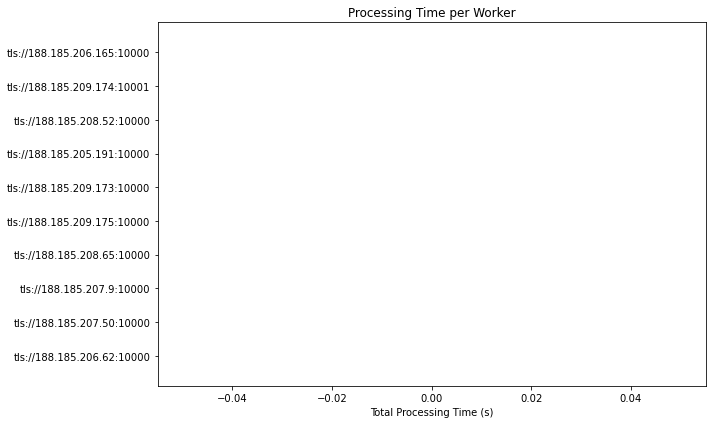

/tmp/ipykernel_25205/4175948195.py:207: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


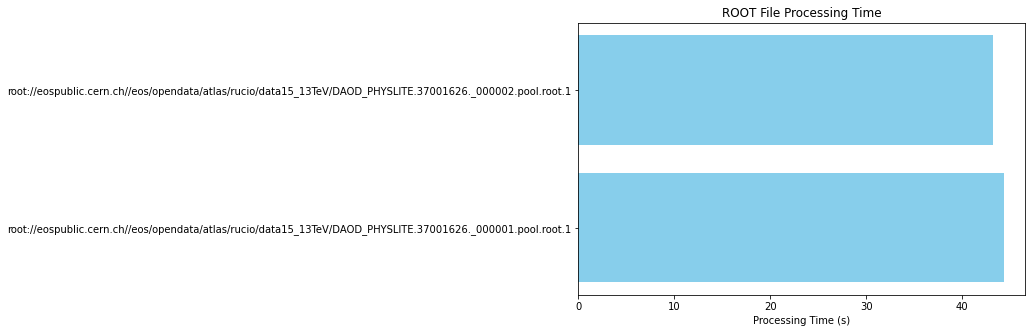

🟢 All files processed. Performance report saved as `dask-report.html`.


In [11]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from dask.distributed import performance_report, Client, get_task_stream
from collections import defaultdict

def plot_task_stream(json_path):


    with open(json_path) as f:
        data = json.load(f)

    workers = sorted(set(d['worker'] for d in data))
    worker_idx = {worker: i for i, worker in enumerate(workers)}

    fig, ax = plt.subplots(figsize=(15, 0.6 * len(workers)))

    for d in data:
        y = worker_idx[d['worker']]
        start = d['start']
        stop = d['stop']
        duration = stop - start
        ax.barh(y, duration, left=start, height=0.4, color='tab:blue', edgecolor='black')

    ax.set_yticks(range(len(workers)))
    ax.set_yticklabels(workers)
    ax.set_xlabel("Time (s)")
    ax.set_title("Dask Task Execution Timeline per Worker")
    plt.tight_layout()
    plt.savefig("dask_task_timeline.png", dpi=150)
    plt.show()

def capture_task_stream(client):
    """
    Captures the start and end times of tasks across workers.
    Uses Dask's built-in task stream logging.
    """
    task_stream = []

    # Get the task stream from the Dask client
    task_stream_data = client.get_task_stream()

    # Parse task events and append to the task stream
    for event in task_stream_data:
        worker = event.get('worker')
        task = event.get('task')
        start = event.get('start')
        end = event.get('end')
        
        if worker and task and start is not None and end is not None:
            task_stream.append({
                'worker': worker,
                'task': task,
                'start_time': start,
                'end_time': end
            })

    return task_stream

def plot_task_timeline(task_stream):
    """
    Plot a time series of tasks per worker.
    """
    if not task_stream:
        print("⚠️ No task stream data to plot.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    worker_colors = {}

    for task in task_stream:
        worker = task['worker']
        start = task['start_time']
        stop = task['end_time']

        # Assign a unique color to each worker
        if worker not in worker_colors:
            worker_colors[worker] = plt.cm.tab20(len(worker_colors) % 20)

        ax.plot([start, stop], [worker, worker], lw=6, color=worker_colors[worker], solid_capstyle='butt')

    ax.set_title("Dask Task Timeline by Worker")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Worker")
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("dask_worker_timeline.png")
    plt.show()


filelist = [
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000001.pool.root.1",
    "root://eospublic.cern.ch//eos/opendata/atlas/rucio/data15_13TeV/DAOD_PHYSLITE.37001626._000002.pool.root.1",
]

def capture_task_stream(client):
    # Capture the task stream to track worker usage
    task_stream = []
    for event in client.get_task_stream():
        # `event` will be a dictionary containing task metadata
        if isinstance(event, dict):  # Ensure it's a dictionary event
            worker = event.get('worker', 'unknown')
            start_time = event.get('start', 0)
            end_time = event.get('end', 0)
            duration = end_time - start_time
            task_stream.append((worker, duration))
    
    return task_stream


def plot_task_timeline(task_stream):
    worker_times = defaultdict(float)
    
    # Sum up the durations per worker
    for worker, duration in task_stream:
        worker_times[worker] += duration
    
    # Plot the time spent by each worker
    workers = list(worker_times.keys())
    durations = list(worker_times.values())
    
    plt.figure(figsize=(10, 6))
    plt.barh(workers, durations, color='lightcoral')
    plt.xlabel("Total Processing Time (s)")
    plt.title("Processing Time per Worker")
    plt.tight_layout()
    plt.savefig("worker_processing_times.png")
    plt.show()

def run(filelist):
    # Initialize client with retry mechanism
    max_retries = 5
    retries = 0
    client = None
    
    while retries < max_retries:
        try:
            client = Client("tls://10.100.139.49:30701")
            # Wait for scheduler to initialize
            time.sleep(2)  # Give scheduler time to connect
            
            # Verify scheduler is ready
            if client.scheduler_info()['services']['dashboard']:
                break
                
            print(f"⚠️ Scheduler not ready, retrying... ({retries + 1}/{max_retries})")
            client.close()
            
        except Exception as e:
            print(f"⚠️ Error initializing Dask client: {str(e)}")
            time.sleep(1)  # Wait before retry
            
        retries += 1
    
    if client is None or not client.scheduler_info():
        raise RuntimeError("Failed to initialize Dask client after multiple attempts.")
        
    timings = []
    all_task_stream = []

    try:
        with performance_report(filename="dask-report.html"):
            for idN, filename in enumerate(filelist):
                print(f"\n📁 Processing file {filename}...")
                start_time = time.time()

                

                df = process_dask(root_file_path=filename, idN=idN)
                task_stream = capture_task_stream(client)

                all_task_stream.extend(task_stream)

                # Ensure columns in column_order
                for col in column_order:
                    if col not in df.columns:
                        df[col] = -99
                df = df[column_order].fillna(-99)
                df_filtered = filter_data(df)

                output_csv = "row.csv"
                output_hdf = "row.h5"
                header = (idN == 0)
                mode = 'w' if idN == 0 else 'a'

                df_filtered.to_csv(output_csv, index=False, header=header, mode=mode)
                with warnings.catch_warnings():
                    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
                    df.to_hdf(output_hdf, key='df', mode=mode)

                duration = time.time() - start_time
                timings.append((filename, duration))
                print(f"✅ Saved rows (file time: {duration:.2f} s)")

    finally:
        client.close()

    plot_task_timeline(all_task_stream)

    filenames, durations = zip(*timings)
    plt.figure(figsize=(8, 5))
    plt.barh(filenames, durations, color='skyblue')
    plt.xlabel("Processing Time (s)")
    plt.title("ROOT File Processing Time")
    plt.tight_layout()
    plt.savefig("processing_times.png")
    plt.show()

    print("🟢 All files processed. Performance report saved as `dask-report.html`.")

if __name__ == "__main__":
    run(filelist)


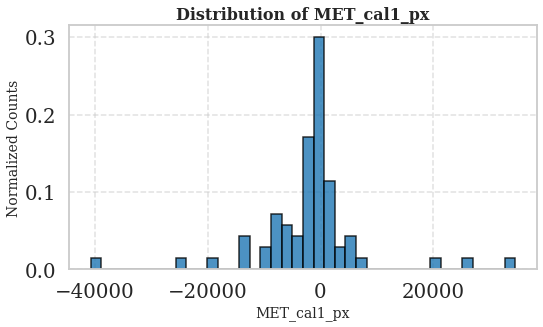

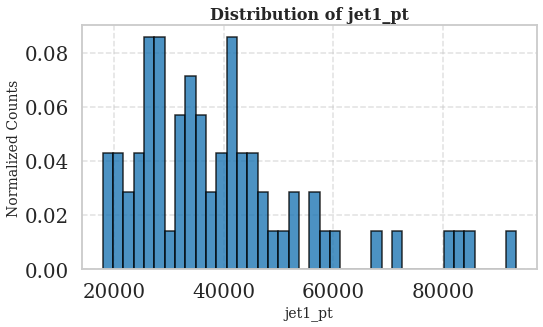

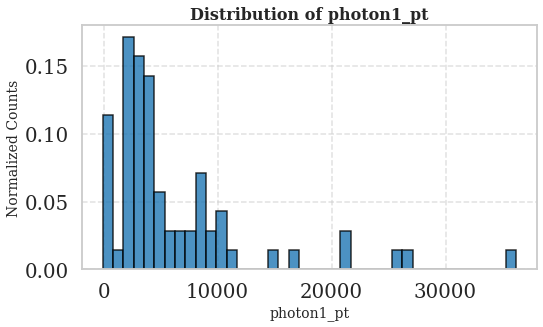

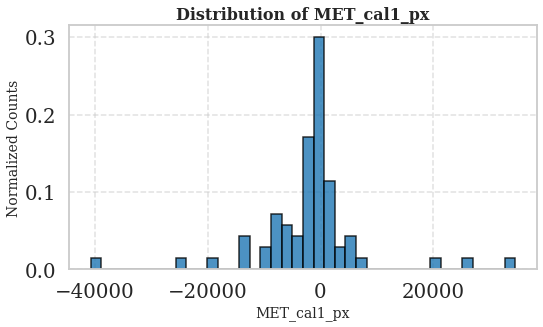

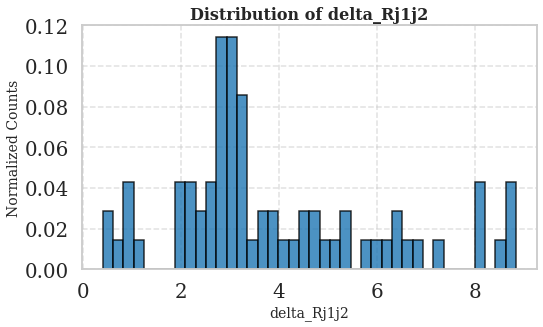

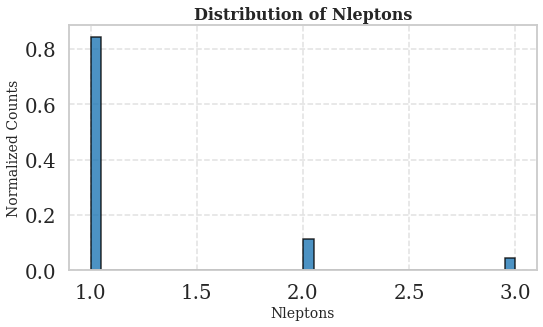

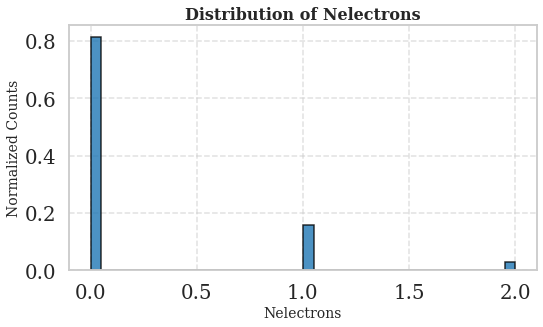

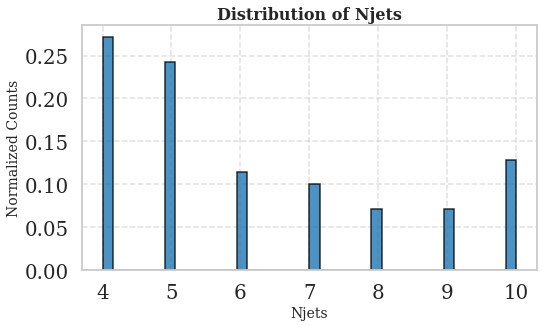

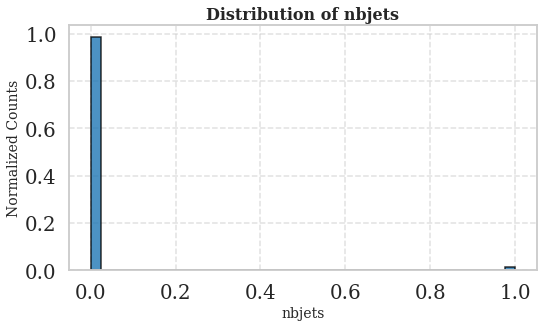

In [12]:
variables_to_plot = ['MET_cal1_px','jet1_pt','photon1_pt', 'MET_cal1_px','delta_Rj1j2','Nleptons', 'Nelectrons', 'Njets', "nbjets"]
df_loaded = pd.read_csv("row.csv")
plot_variable_histograms(df_loaded, variables_to_plot, bins=40, normalize=True, log_scale=False)